In [7]:
import matplotlib.pyplot as plt
import cv2
import numpy as np


In [8]:
def show(img, gray=False):
    plt.axis('off')
    if gray:
        plt.imshow(img, plt.cm.binary)
        plt.show()
        return
    plt.imshow(img)
    plt.show()



In [9]:
def hair_density(image, label, show_images=False):
    blur_image = cv2.blur(image,(10,10))
    grayScale = cv2.cvtColor(blur_image, cv2.COLOR_RGB2GRAY)
    if show_images:
        show(grayScale, True)
    kernel = cv2.getStructuringElement(1,(17,17))
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    _,threshold = cv2.threshold(blackhat,10,255,cv2.THRESH_BINARY)
    if show_images:
        show(threshold)
    num = cv2.countNonZero(threshold)
    size = threshold.shape[-1]*threshold.shape[1]
    return num/size


ISIC_0034533
1
0.23535493827160495
ISIC_0034548
0
0.08085648148148149


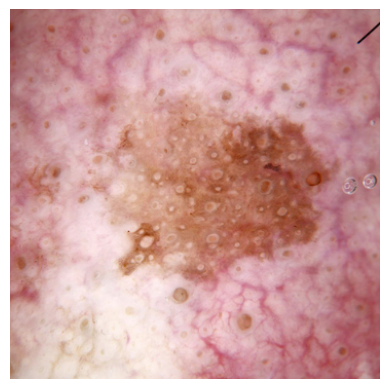

ISIC_0034600
1
0.09328703703703704
ISIC_0034626
1
0.09189814814814815
ISIC_0034655
0
0.07635030864197531


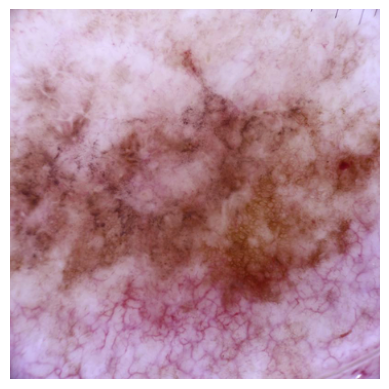

ISIC_0034688
1
0.07594907407407407
ISIC_0034725
1
0.1308641975308642
ISIC_0034740
1
0.10888117283950617
ISIC_0034772
1
0.1159645061728395
ISIC_0034790
1
0.14439814814814814
ISIC_0034810
1
0.15779320987654322
ISIC_0034823
1
0.10432098765432099
ISIC_0034837
1
0.13113425925925926
ISIC_0034868
1
0.07583333333333334
ISIC_0034892
1
0.0987962962962963
ISIC_0034919
1
0.22418981481481481
ISIC_0034955
1
0.09715277777777778
ISIC_0034959
0
0.10631172839506173


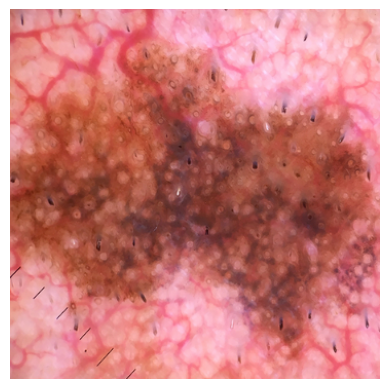

ISIC_0034973
1
0.08632716049382716
ISIC_0035093
1
0.19898148148148148
ISIC_0035118
1
0.0971604938271605
ISIC_0035121
1
0.09309413580246914
ISIC_0035126
1
0.07770061728395061
ISIC_0035207
0
0.14299382716049383


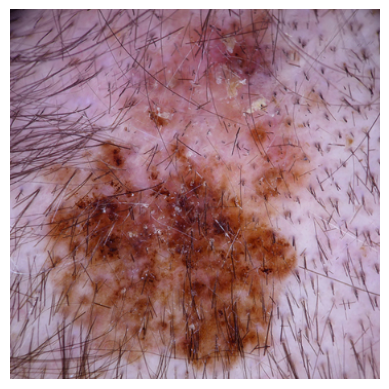

ISIC_0035236
1
0.22653549382716048
ISIC_0035257
1
0.22237654320987654
ISIC_0035281
1
0.13104166666666667
ISIC_0035351
0
0.07185185185185185


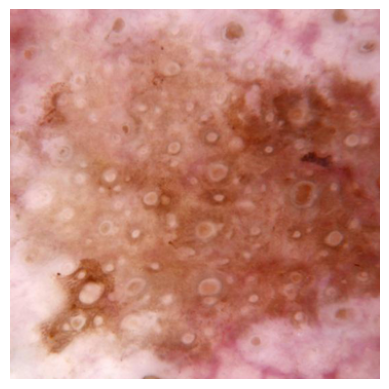

ISIC_0035395
1
0.12152777777777778
ISIC_0035397
0
0.09251543209876543


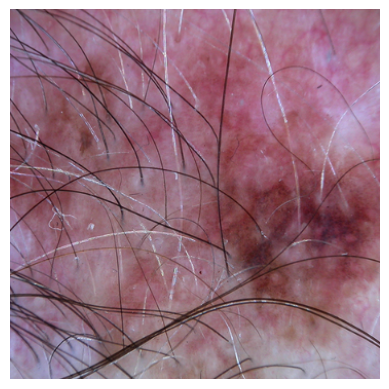

ISIC_0035423
1
0.09611882716049383
ISIC_0035445
1
0.09075617283950617
ISIC_0035531
1
0.0901388888888889
ISIC_0035550
0
0.07708333333333334


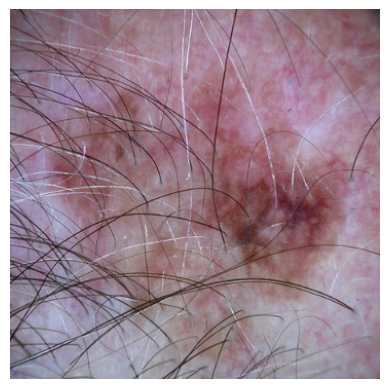

ISIC_0035662
1
0.1835956790123457
ISIC_0035686
1
0.08505401234567901
ISIC_0035688
1
0.20439814814814813
ISIC_0035707
1
0.13291666666666666
ISIC_0035728
1
0.19991512345679013
ISIC_0035743
1
0.0766358024691358
ISIC_0035757
1
0.13327160493827162
ISIC_0035795
1
0.13160493827160494
ISIC_0035808
1
0.08171296296296296
ISIC_0035820
1
0.07589506172839507
ISIC_0035894
0
0.07211419753086419


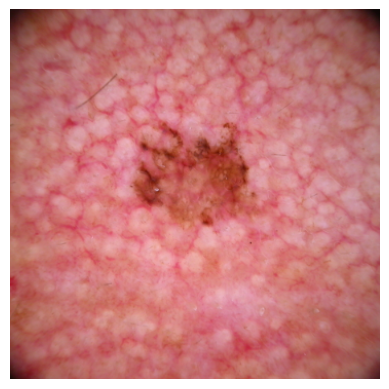

ISIC_0035981
1
0.09446759259259259
ISIC_0035988
1
0.11942901234567901
ISIC_0035998
1
0.13166666666666665
ISIC_0036036
1
0.09191358024691358
ISIC_0036048
1
0.1170216049382716
Found 50 hair images
{0: 8, 1: 42}
           isic_id  hair_density  high_hair_density
0     ISIC_0034524      0.000594                  0
1     ISIC_0034525      0.000247                  0
2     ISIC_0034527      0.028596                  0
3     ISIC_0034528      0.001559                  0
4     ISIC_0034529      0.040532                  0
...            ...           ...                ...
1075  ISIC_0036056      0.033681                  0
1076  ISIC_0036057      0.002708                  0
1077  ISIC_0036058      0.002971                  0
1078  ISIC_0036059      0.006867                  0
1079  ISIC_0036061      0.056651                  0

[1080 rows x 3 columns]


In [10]:
import pandas as pd
from torch.utils.data import DataLoader
from dataset import get_dataset

data_set = get_dataset("test", use_plain_transform=True, id_as_label=True, num_classes=2)

data_loader = DataLoader(data_set, batch_size=1, shuffle=False, num_workers=0)

hair_densities = {"isic_id": [], "hair_density": [], "high_hair_density": []}
counter = 0
label_count ={0: 0, 1:0}
for batch, labels in data_loader:
    isic_id = labels[0][0]
    img = batch[0].permute(1,2,0).numpy()
    img = img.astype(np.uint8)
    density = hair_density(img, labels, show_images=False)
    if density >= 0.07:
        print(isic_id)
        label = labels[1][0].item()
        label_count[label] = label_count[label]+1
        print(labels[1][0].item())
        print(density)
        if (labels[1][0].item()==0):
            show(img)
        counter += 1
        hair_densities["high_hair_density"].append(1)
    else:
        hair_densities["high_hair_density"].append(0)
    hair_densities["isic_id"].append(isic_id)
    hair_densities["hair_density"].append(density)
    
print(f"Found {counter} hair images")
print(label_count)

dataframe_hair_densities = pd.DataFrame(hair_densities)
print(dataframe_hair_densities)
dataframe_hair_densities.to_csv("hair_densities.csv", index=False)
